In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
# Dostop do datoteke
file_path = '../PrometneNesreče.csv'
data = pd.read_csv(file_path)

C:\Users\Hana\AppData\Local\Temp\ipykernel_25620\2677043888.py:3: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


#### Dodajanje stolpcev

In [26]:
# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')

day_translation = {
    'Monday': 'Ponedeljek',
    'Tuesday': 'Torek',
    'Wednesday': 'Sreda',
    'Thursday': 'Četrtek',
    'Friday': 'Petek',
    'Saturday': 'Sobota',
    'Sunday': 'Nedelja'
}
day_order_slo = ['Ponedeljek', 'Torek', 'Sreda', 'Četrtek', 'Petek', 'Sobota', 'Nedelja']

month_translation = {
    'January': 'Januar', 'February': 'Februar', 'March': 'Marec',
    'April': 'April', 'May': 'Maj', 'June': 'Junij',
    'July': 'Julij', 'August': 'Avgust', 'September': 'September',
    'October': 'Oktober', 'November': 'November', 'December': 'December'
}
month_order_slo = ['Januar', 'Februar', 'Marec', 'April', 'Maj', 'Junij', 'Julij', 'Avgust', 'September', 'Oktober', 'November', 'December']

data['Day_EN'] = data['NastanekDatumCas'].dt.day_name()
data['Day_SLO'] = data['Day_EN'].map(day_translation)

data['Mesec_EN'] = data['NastanekDatumCas'].dt.month_name()
data['Mesec_SLO'] = data['Mesec_EN'].map(month_translation)

data['Datum'] = data['NastanekDatumCas'].dt.date
data['Ura'] = data['NastanekDatumCas'].dt.hour

data['Teden'] = data['NastanekDatumCas'].dt.to_period('W').apply(lambda r: r.start_time)

data['Leto'] = data['NastanekDatumCas'].dt.year

# Severity
conditions = [
    (data['LjudjePoskodovani'] == 0) & (data['LjudjeMrtvi'] == 0),
    (data['LjudjePoskodovani'] != 0) & (data['LjudjeMrtvi'] == 0),
    (data['LjudjeMrtvi'] != 0)
]

# Določi oznake
severity_labels = ['no_injury', 'injury', 'death']

# Dodaj stolpec za severity
data['Severity'] = np.select(conditions, severity_labels, default='unknown')
# display(data)

# Število nesreč po letih

In [34]:
# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')

# Za vsak vnos pridobi, katero leto je blo
years = data['NastanekDatumCas'].dt.year

# Preštej število nesreč za vsak mesec
accidents_per_year = years.value_counts().sort_index()

# print(accidents_per_year)

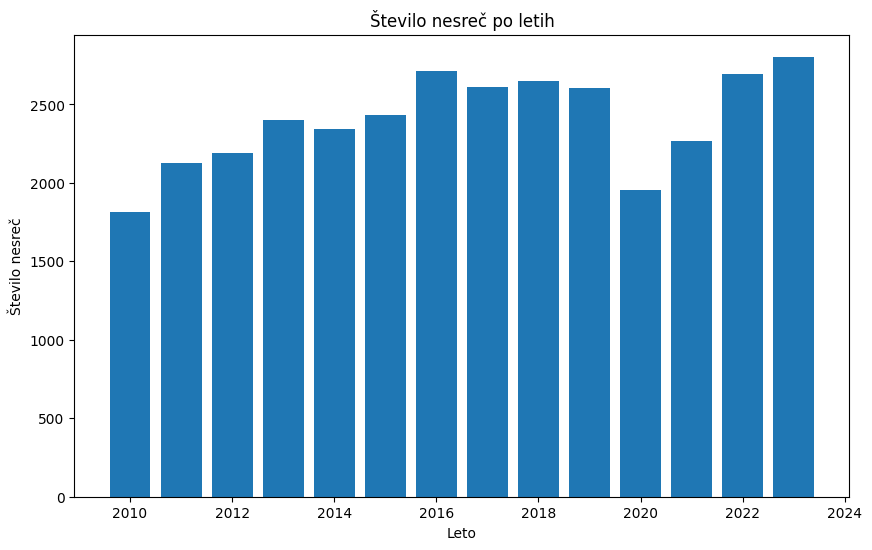

In [28]:
# Stolpčni diagram
plt.figure(figsize=(10, 6))
plt.bar(accidents_per_year.index, accidents_per_year.values)

plt.xlabel('Leto')
plt.ylabel('Število nesreč')
plt.title('Število nesreč po letih')

plt.show()

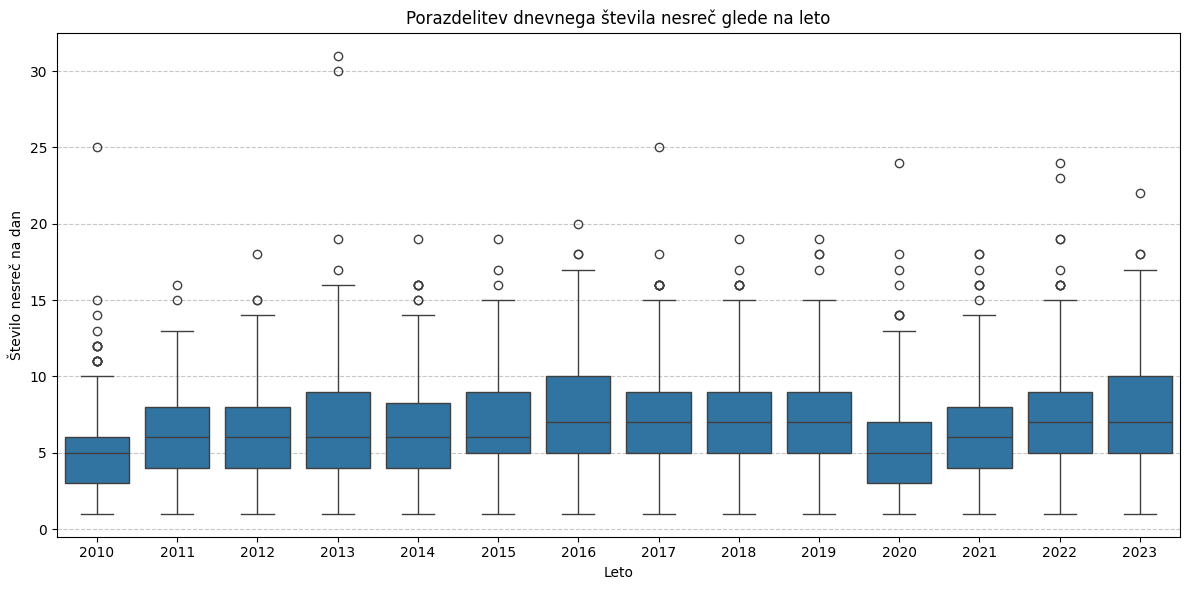

In [32]:
# BOXPLOT
# Najprej grupiram in preštejem nesreče
grouped = data.groupby('Datum').size()

# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')
# display(df_accidents)

# Izluščim leto iz datuma
df_accidents['Datum'] = pd.to_datetime(df_accidents['Datum'], format='ISO8601', errors='coerce')
df_accidents['Leto'] = df_accidents['Datum'].dt.year

df_accidents['Leto'] = df_accidents['Leto'].astype(int)   # Da bodo leta smatrana kot številke in ne stringi. Da se bodo pravilno razporedila po x-osi.

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='Leto', y='accident_count')
plt.title('Porazdelitev dnevnega števila nesreč glede na leto')
plt.xlabel('Leto')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **Resnost posledic prometnih nesreč**

Tri kategorije nesreč:
- **Nesreče brez poškodovancev**: udeleženci niso bili poškodovani in nihče ni umrl
- **Nesreče s poškodbami**: nekateri udeleženci so bili poškodovani, vendar nihče ni umrl
- **Nesreče s smrtnim izidom**: vsaj eden od udeležencev je umrl (v nesreči so bili lahko tudi drugi, ki so bili poškodovani, vendar take nesreče ne štejem v kategorijo "Nesreče s poškodbami")

## Nesreče brez poškodovancev

In [6]:
# Nesreče brez poškodovancev in smrtnih žrtev
mild_accidents_entries = data[(data['LjudjeMrtvi'] == 0) & (data['LjudjePoskodovani'] == 0)]

# Za vsak vnos pridobi mesec nesreče
mild_years = mild_accidents_entries['NastanekDatumCas'].dt.year

mild_accidents_per_year = mild_years.value_counts().sort_index()

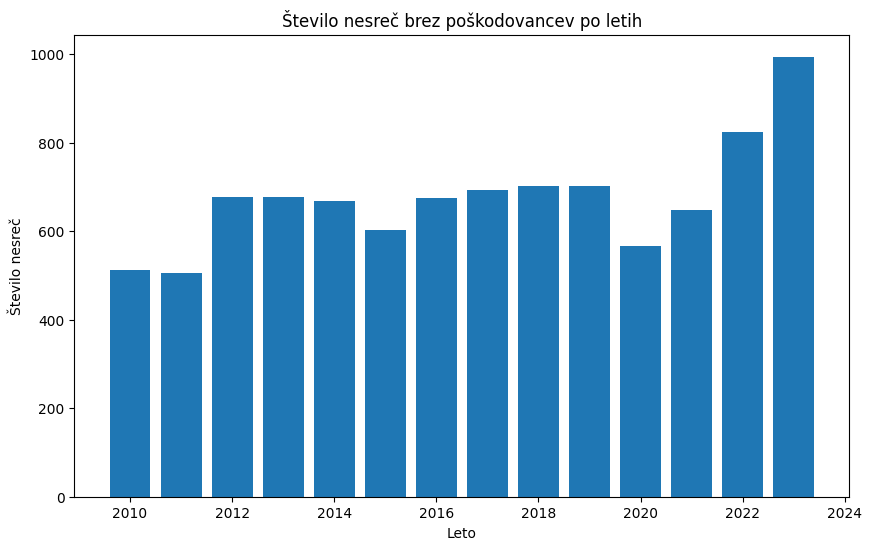

In [7]:
# Stolpčni diagram
plt.figure(figsize=(10, 6))
plt.bar(mild_accidents_per_year.index, mild_accidents_per_year.values)

plt.xlabel('Leto')
plt.ylabel('Število nesreč')
plt.title('Število nesreč brez poškodovancev po letih')

plt.show()

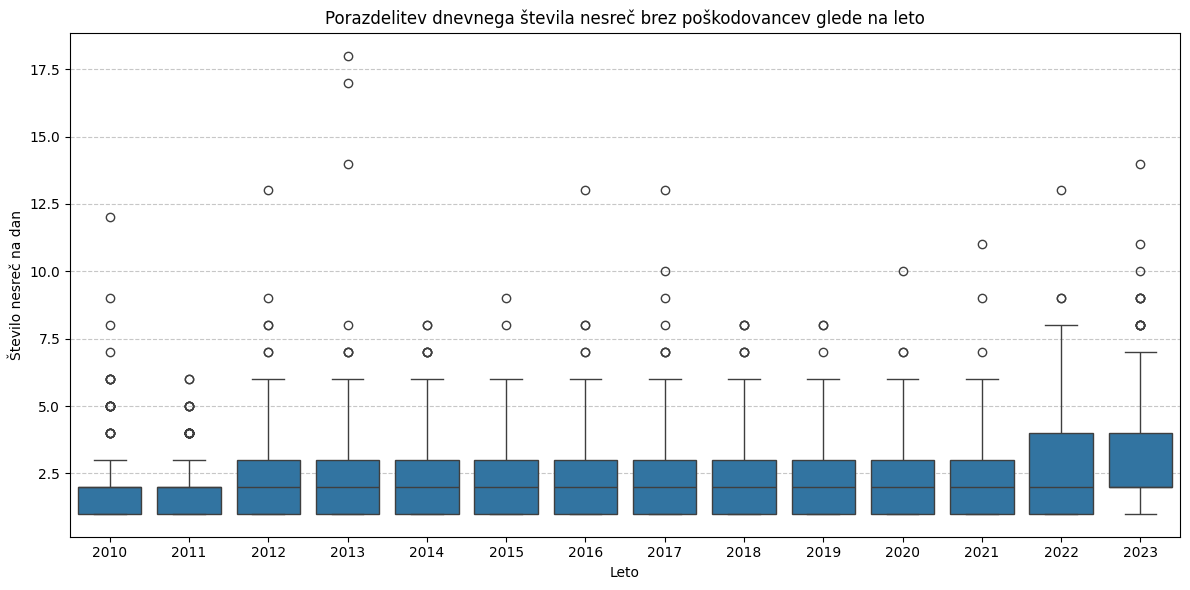

In [16]:
# BOXPLOT
mask_no_injury = (data['Severity'] == 'no_injury')
df_no_injury = data[mask_no_injury]

# Najprej grupiram in preštejem nesreče
grouped = df_no_injury.groupby(['Datum']).size()

# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')
# display(df_accidents)

# Izluščim leto iz datuma
df_accidents['Leto'] = df_accidents['Datum'].dt.year

df_accidents['Leto'] = df_accidents['Leto'].astype(int)   # Da bodo leta smatrana kot številke in ne stringi. Da se bodo pravilno razporedila po x-osi.

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='Leto', y='accident_count')
plt.title('Porazdelitev dnevnega števila nesreč brez poškodovancev glede na leto')
plt.xlabel('Leto')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Nesreče s poškodbami

In [8]:
# Nesreče s poškodbami
injury_accidents_entries = data[(data['LjudjeMrtvi'] == 0) & (data['LjudjePoskodovani'] != 0)]

# Za vsak vnos pridobi mesec nesreče
injury_years = injury_accidents_entries['NastanekDatumCas'].dt.year

injury_accidents_per_year = injury_years.value_counts().sort_index()

Text(0.5, 1.0, 'Število nesreč s poškodbami po letih')

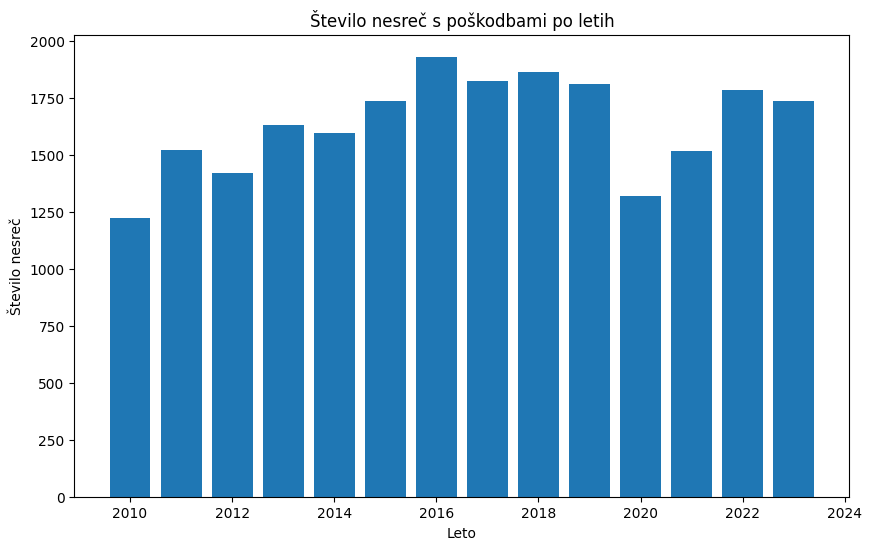

In [9]:
# Stolpčni diagram
plt.figure(figsize=(10, 6))
plt.bar(injury_accidents_per_year.index, injury_accidents_per_year.values)

plt.xlabel('Leto')
plt.ylabel('Število nesreč')
plt.title('Število nesreč s poškodbami po letih')

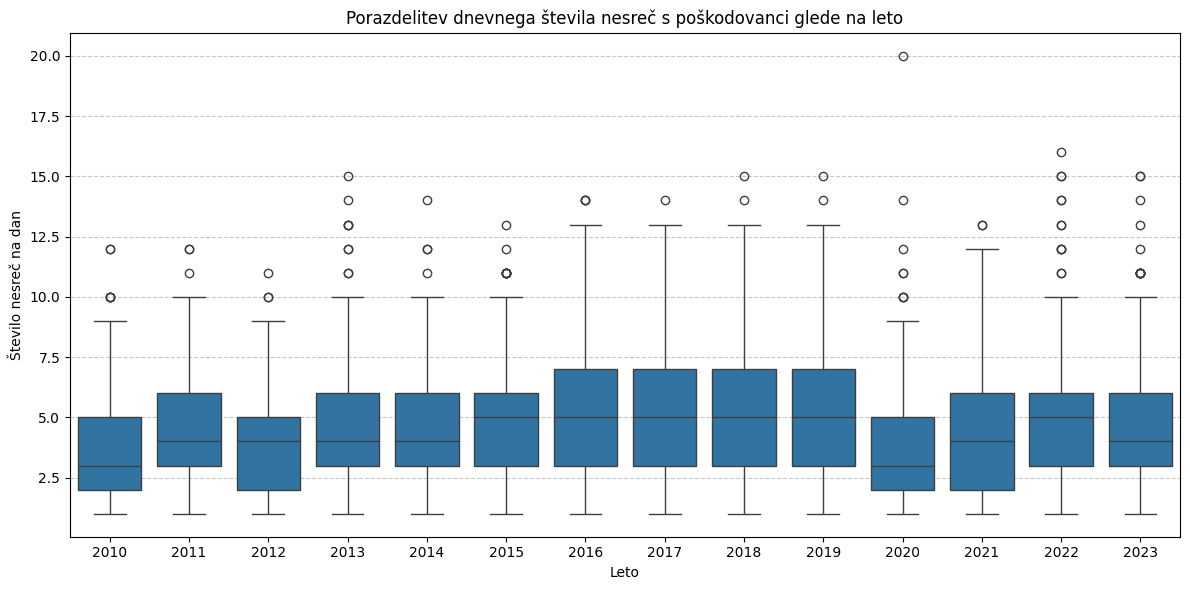

In [ ]:
# BOXPLOT
mask_injury = (data['Severity'] == 'injury')
df_injury = data[mask_injury]

# Najprej grupiram in preštejem nesreče
grouped = df_injury.groupby(['Datum']).size()

# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')
# display(df_accidents) 

# Izluščim leto iz datuma
df_accidents['Leto'] = df_accidents['Datum'].dt.year

df_accidents['Leto'] = df_accidents['Leto'].astype(int)   # Da bodo leta smatrana kot številke in ne stringi. Da se bodo pravilno razporedila po x-osi.

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='Leto', y='accident_count')
plt.title('Porazdelitev dnevnega števila nesreč s poškodovanci glede na leto')
plt.xlabel('Leto')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Nesreče s smrtnim izidom

In [10]:
# Nesreče s smrtnimi žrtvami
death_accidents_entries = data[(data['LjudjeMrtvi'] != 0)]

# Za vsak vnos pridobi mesec nesreče
death_years = death_accidents_entries['NastanekDatumCas'].dt.year

death_accidents_per_year = death_years.value_counts().sort_index()

Text(0.5, 1.0, 'Število nesreč s smrtnimi žrtvami po letih')

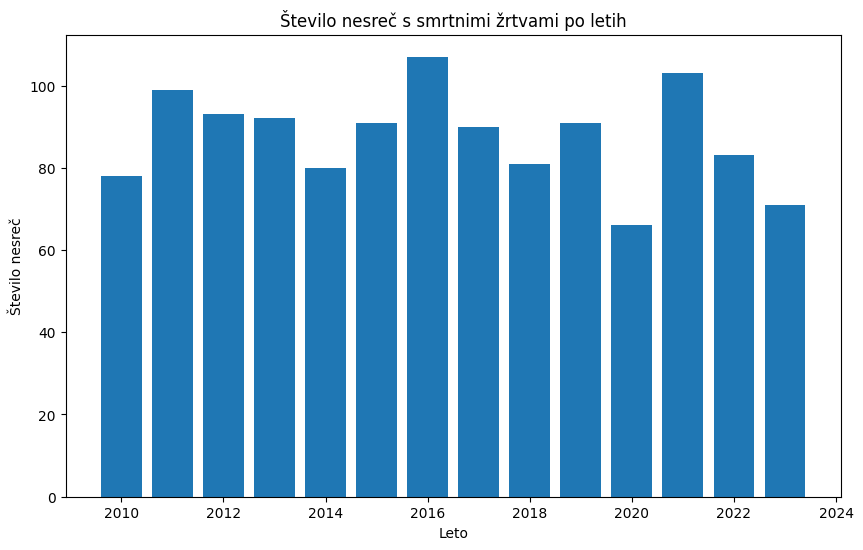

In [11]:
# Stolpčni diagram
plt.figure(figsize=(10, 6))
plt.bar(death_accidents_per_year.index, death_accidents_per_year.values)

plt.xlabel('Leto')
plt.ylabel('Število nesreč')
plt.title('Število nesreč s smrtnimi žrtvami po letih')

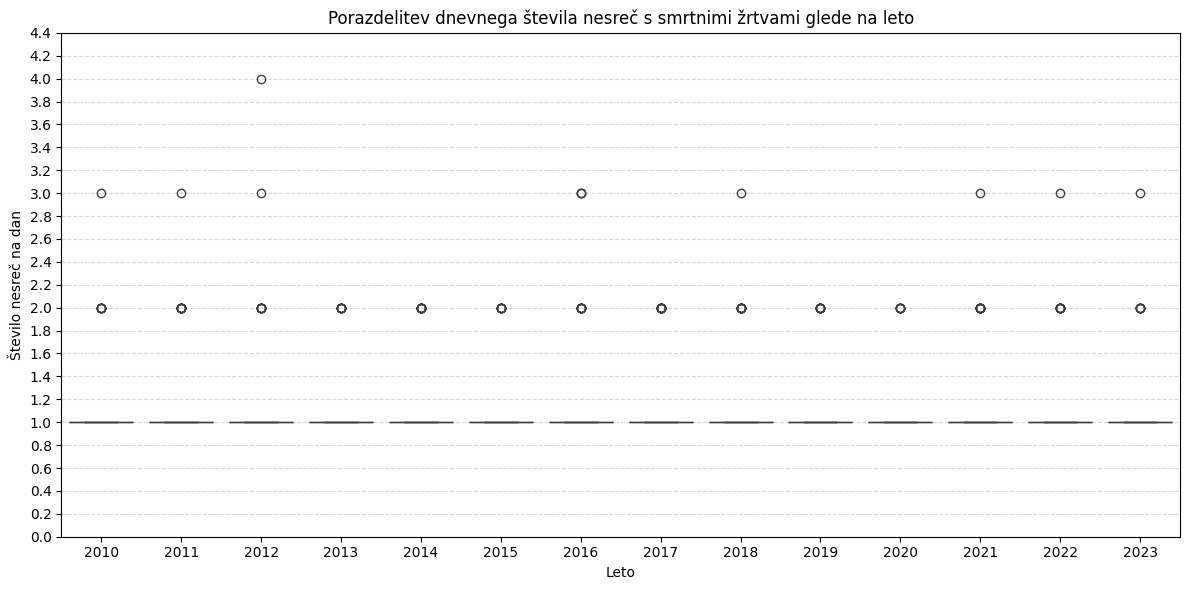

In [20]:
# BOXPLOT
mask_death = (data['Severity'] == 'death')
df_death = data[mask_death]

# Najprej grupiram in preštejem nesreče
grouped = df_death.groupby(['Datum']).size()

# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')
# display(df_accidents)

# Izluščim leto iz datuma
df_accidents['Leto'] = df_accidents['Datum'].dt.year

df_accidents['Leto'] = df_accidents['Leto'].astype(int)   # Da bodo leta smatrana kot številke in ne stringi. Da se bodo pravilno razporedila po x-osi.

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='Leto', y='accident_count')
plt.title('Porazdelitev dnevnega števila nesreč s smrtnimi žrtvami glede na leto')
plt.xlabel('Leto')
plt.ylabel('Število nesreč na dan')
plt.yticks(np.arange(0, df_accidents['accident_count'].max() + 0.5, 0.2))
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Prikaz števila vseh treh kategorij nesreč

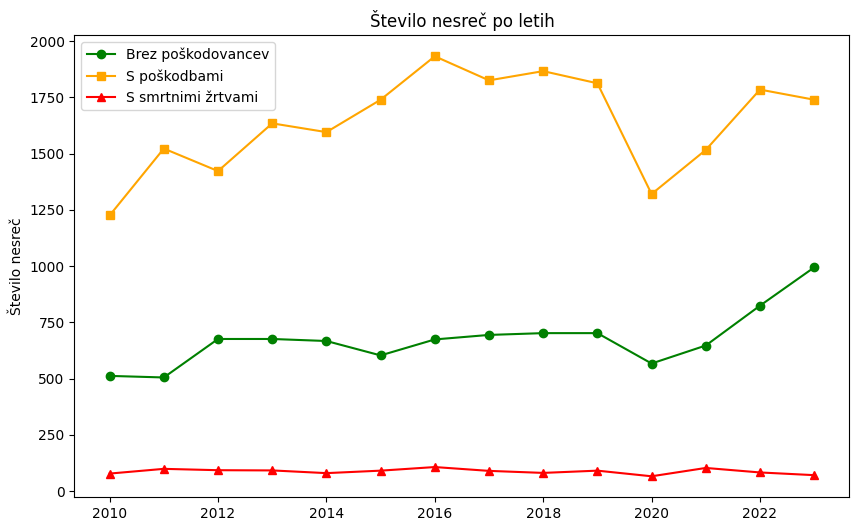

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(mild_accidents_per_year.index, mild_accidents_per_year.values, marker='o', linestyle='-', label='Brez poškodovancev', color='green')
plt.plot(mild_accidents_per_year.index, injury_accidents_per_year.values, marker='s', linestyle='-', label='S poškodbami', color='orange')
plt.plot(mild_accidents_per_year.index, death_accidents_per_year.values, marker='^', linestyle='-', label='S smrtnimi žrtvami', color='red')

plt.ylabel('Število nesreč')
plt.title('Število nesreč po letih')
plt.legend()

plt.show()

## Prikaz normaliziranih vrednosti za lažjo primerjavo

X_norm = (X - X_min) / (X_max - X_min)

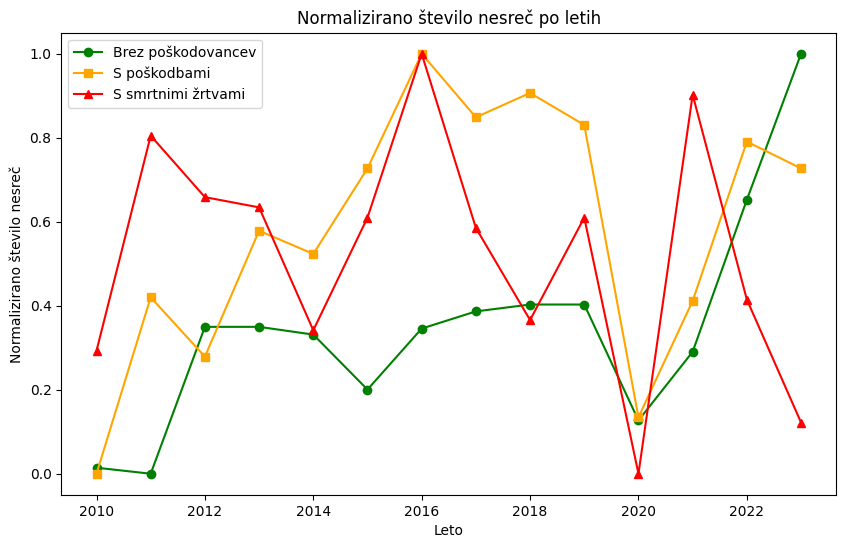

In [13]:
# Normaliziranje
mild_norm = (mild_accidents_per_year.values - np.min(mild_accidents_per_year.values)) / (np.max(mild_accidents_per_year.values) - np.min(mild_accidents_per_year.values))
injury_norm = (injury_accidents_per_year.values - np.min(injury_accidents_per_year.values)) / (np.max(injury_accidents_per_year.values) - np.min(injury_accidents_per_year.values))
death_norm = (death_accidents_per_year.values - np.min(death_accidents_per_year.values)) / (np.max(death_accidents_per_year.values) - np.min(death_accidents_per_year.values))

plt.figure(figsize=(10, 6))

plt.plot(mild_accidents_per_year.index, mild_norm, marker='o', linestyle='-', label='Brez poškodovancev', color='green')
plt.plot(mild_accidents_per_year.index, injury_norm, marker='s', linestyle='-', label='S poškodbami', color='orange')
plt.plot(mild_accidents_per_year.index, death_norm, marker='^', linestyle='-', label='S smrtnimi žrtvami', color='red')

plt.xlabel('Leto')
plt.ylabel('Normalizirano število nesreč')
plt.title('Normalizirano število nesreč po letih')
plt.legend()

plt.show()

Opažanja: Nekaj se je moralo spremeniti v beleženju prometnih nesreč leta 2010, ker so številke pred 2010 popolnoma drugačne, kakor potem.

### Boxplot

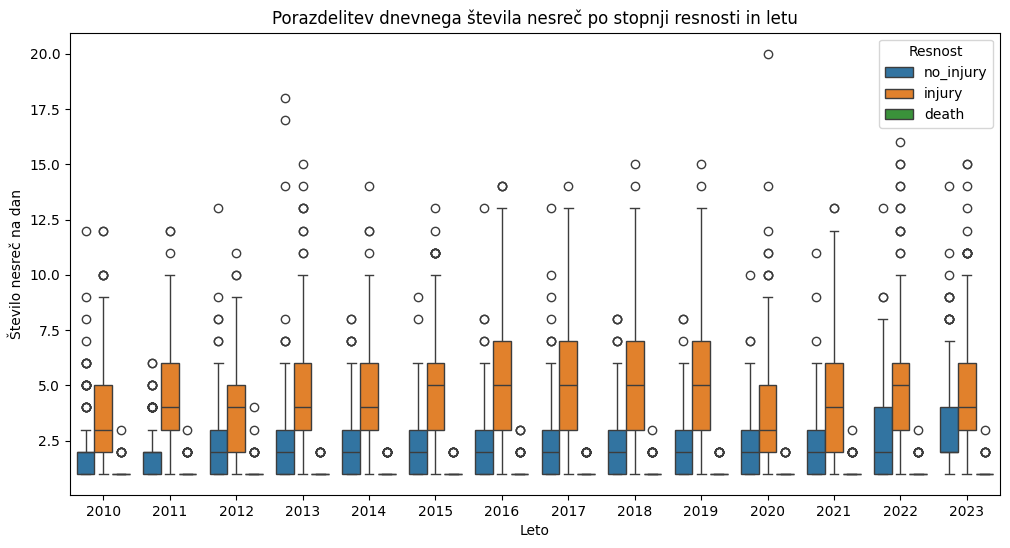

In [22]:
# Grupiraj in preštej število nesreč
grouped = data.groupby(['Datum', 'Severity']).size()

# Rezultat grupiranja pretvori v dataframe in stolpec s preštetimi prometnimi nesrečami poimenuj 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

df_accidents['Leto'] = df_accidents['Datum'].dt.year
df_accidents['Leto'] = df_accidents['Leto'].astype(int)   # Da bodo leta smatrana kot številke in ne stringi. Da se bodo pravilno razporedila po x-osi.

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='Leto', y='accident_count', hue='Severity')

plt.xlabel('Leto')
plt.ylabel('Število nesreč na dan')
plt.title('Porazdelitev dnevnega števila nesreč po stopnji resnosti in letu')
plt.legend(title='Resnost')
plt.show()

### Heatmap

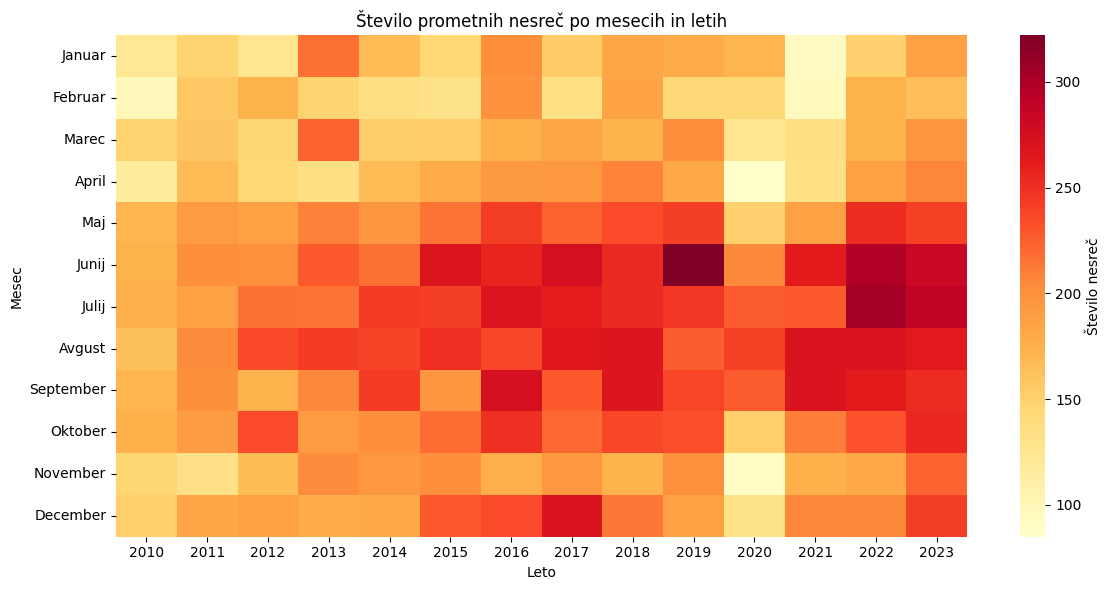

In [ ]:
grouped = data.groupby(['Leto', 'Mesec_SLO']).size()
grouped = grouped.reset_index(name='accident_count')

# Mesece razporedi po vrstnem redu
cat_type_month = CategoricalDtype(categories=month_order_slo, ordered=True)
grouped['Mesec_SLO'] = grouped['Mesec_SLO'].astype(cat_type_month) 
grouped = grouped.sort_values(['Mesec_SLO'])

grouped['Leto'] = grouped['Leto'].astype(int)   # Da bodo leta smatrana kot številke in ne stringi. Da se bodo pravilno razporedila po x-osi.

df_heatmap = grouped.pivot(index='Mesec_SLO', columns='Leto', values='accident_count').fillna(0)
# display(df_heatmap)

# Heatmap
plt.figure(figsize=(12, 6))

sns.heatmap(df_heatmap, 
            annot=False,
            cmap='YlOrRd',
            cbar_kws={'label': 'Število nesreč'})
plt.xlabel('Leto')
plt.ylabel('Mesec')
plt.title('Število prometnih nesreč po mesecih in letih')
plt.tight_layout()
plt.show()